# Captum & Lucid Differences

In Captum, changes have been made to the way that `FFTImage` and `RandomScale` and thus results may be slightly different to those of their Lucid counterparts. For this tutorial we prepared more Lucid-like versions of both classes in order to better examine the differences, and for those wishing to use the original behavior with Captum.

In [2]:
from typing import Callable, Tuple, List, Optional, Sequence, Union

import torch
import torch.nn as nn
import torch.nn.functional as F

import captum.optim as opt
from captum.optim.models import googlenet

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Image Parameterization & Transform Differences

## Differences in the RandomScale Transform

While both Captum and Lucid's RandomScale transform accomplish the same, they go about it slightly differently. In the case of Captum, an affine transform matrix is used while the tensor shape stays the same. This means that in some cases a background is introduced. For Lucid, an image resizing operation is used that changes the tensor shape with no added background values.

Below we recreate Lucid's RandomScale transform using a wrapper around [`torch.nn.functional.interpolate()`](https://pytorch.org/docs/stable/generated/torch.nn.functional.interpolate.html):

In [3]:
class RandomScaleLucid(nn.Module):
    """
    Apply random rescaling on a NCHW tensor.
    """

    __constants__ = [
        "scale",
        "align_corners",
        "has_align_corners",
        "recompute_scale_factor",
        "has_recompute_scale_factor",
    ]

    def __init__(
        self,
        scale: Union[Sequence[int], Sequence[float], Tensor],
        mode: str = "bilinear",
        align_corners: Optional[bool] = False,
        recompute_scale_factor: bool = False,
    ) -> None:
        """
        Args:

            scale (float, sequence): Tuple of rescaling values to randomly select from.
            mode (str, optional): Interpolation mode to use. See documentation of
                F.interpolate for more details. One of; "bilinear", "nearest", "area",
                or "bicubic".
                Default: "bilinear"
            align_corners (bool, optional): Whether or not to align corners. See
                documentation of F.interpolate for more details.
                Default: False
            recompute_scale_factor (bool, optional): Whether or not to recompute the
                scale factor See documentation of F.interpolate for more details.
                Default: False
        """
        super().__init__()
        assert hasattr(scale, "__iter__")
        if torch.is_tensor(scale):
            assert cast(torch.Tensor, scale).dim() == 1
            scale = scale.tolist()
        assert len(scale) > 0
        self.scale = [float(s) for s in scale]
        self.mode = mode
        self.align_corners = align_corners if mode not in ["nearest", "area"] else None
        self.recompute_scale_factor = recompute_scale_factor
        self.has_align_corners = torch.__version__ >= "1.3.0"
        self.has_recompute_scale_factor = torch.__version__ >= "1.6.0"

    def _scale_tensor(self, x: torch.Tensor, scale: float) -> torch.Tensor:
        if self.has_align_corners:
            if self.has_recompute_scale_factor:
                x = F.interpolate(
                    x,
                    scale_factor=scale,
                    mode=self.mode,
                    align_corners=self.align_corners,
                    recompute_scale_factor=self.recompute_scale_factor,
                )
            else:
                x = F.interpolate(
                    x,
                    scale_factor=scale,
                    mode=self.mode,
                    align_corners=self.align_corners,
                )
        else:
            x = F.interpolate(x, scale_factor=scale, mode=self.mode)
        return x

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Randomly scale an NCHW image tensor.

        Args:

            x (torch.Tensor): NCHW image tensor to randomly scale.

        Returns:
            **x** (torch.Tensor): A randomly scaled NCHW image *tensor*.
        """
        assert x.dim() == 4

        n = int(
            torch.randint(
                low=0,
                high=len(self.scale),
                size=[1],
                dtype=torch.int64,
                layout=torch.strided,
                device=x.device,
            ).item()
        )
        scale = self.scale[n]
        return self._scale_tensor(x, scale)

Below we can see the key differences between both RandomScale transforms in action.

Original Image torch.Size([1, 3, 54, 208])


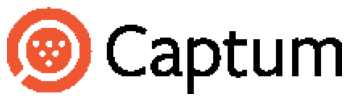

In [4]:
# Load & display the test image
test_image = opt.ImageTensor.open(
    "https://raw.githubusercontent.com/pytorch/captum/master/website/static/img/captum_logo.png"
).unsqueeze(0) # Shift colors a bit so that we can better see the background.

print("Original Image", test_image.shape)
test_image.show()

Captum RandomScale shape with a scale of 1.5: torch.Size([1, 3, 54, 208])


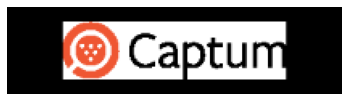


Lucid-like RandomScale shape of 1.5: torch.Size([1, 3, 81, 312])


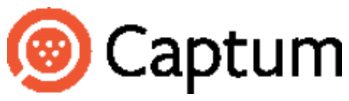


Captum RandomScale shape with a scale of 0.5: torch.Size([1, 3, 54, 208])


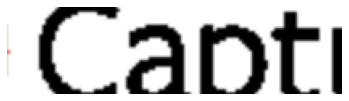


Lucid-like RandomScale shape of 0.5: torch.Size([1, 3, 27, 104])


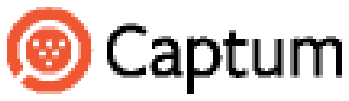

In [5]:
scale_list = [1.5] # Use only one value so both outputs are the same

# Load transforms
random_scale_captum = opt.transforms.RandomScale(scale_list)
random_scale_lucid = RandomScaleLucid(scale_list)

# Run test image through transforms
output_captum = random_scale_captum(test_image)
output_lucid = random_scale_lucid(test_image)

# Show rescaled images
print("Captum RandomScale shape with a scale of " + str(scale_list[0]) + ":", output_captum.shape)
output_captum.show()
print("\nLucid-like RandomScale shape of " +str(scale_list[0]) + ":", output_lucid.shape)
output_lucid.show()


# Repeat the above experiment with a smaller scale value
scale_list = [0.5]

# Load transforms
random_scale_captum = opt.transforms.RandomScale(scale_list)
random_scale_lucid = RandomScaleLucid(scale_list)

# Run test image through transforms
output_captum = random_scale_captum(test_image)
output_lucid = random_scale_lucid(test_image)

# Show rescaled images
print("\nCaptum RandomScale shape with a scale of " + str(scale_list[0]) + ":", output_captum.shape)
output_captum.show()
print("\nLucid-like RandomScale shape of " +str(scale_list[0]) + ":", output_lucid.shape)
output_lucid.show()

## Differences in FFTImage parameterization

Captum's FFTImage was designed as an improved version of Lucid's FFTImage and as such there are a number of changes.

* FFT operations are normalized.

* The scale tensor is not multiplied by the square root of image `height` times `width`.

* Outputs are divided by `4.0`, and optional `init` inputs are multiplied by `4.0`.

Note that these changes will require changing the learning rate in `InputOptimization`'s `optimize` function.

In [6]:
TORCH_VERSION = torch.__version__


class FFTImageLucid(opt.images.ImageParameterization):
    """
    Parameterize an image using inverse real 2D FFT. In this version of FFTImage,
    output image tensors are divided by 4.0 and fft operations are normalized. If you
    provide an init tensor created from an image, it should be multiplied by 4.0
    beforehand. The scale tensor also is not multiplied by the square root of height
    times width.

    Args:

        size (Tuple[int, int]): The H & W dimensions to use for creating the
            nn.Parameter tensor.
        channels (int, optional): The number of channels to create.
        batch (int, optional): The number of batches to create.
        init (torch.tensor, optional): Optionally specify a tensor to use instead of
            creating one.
    """

    def __init__(
        self,
        size: Tuple[int, int] = None,
        channels: int = 3,
        batch: int = 1,
        init: Optional[torch.Tensor] = None,
    ) -> None:
        super().__init__()
        if init is None:
            assert len(size) == 2
            self.size = size
        else:
            assert init.dim() == 3 or init.dim() == 4
            if init.dim() == 3:
                init = init.unsqueeze(0)
            self.size = (init.size(2), init.size(3))
        self.torch_rfft, self.torch_irfft, self.torch_fftfreq = self.get_fft_funcs()

        frequencies = self.rfft2d_freqs(*self.size)
        scale = 1.0 / torch.max(
            frequencies,
            torch.full_like(frequencies, 1.0 / (max(self.size[0], self.size[1]))),
        )
        spectrum_scale = scale[None, :, :, None]

        if init is None:
            coeffs_shape = (
                batch,
                channels,
                self.size[0],
                self.size[1] // 2 + 1,
                2,
            )
            random_coeffs = torch.randn(
                coeffs_shape
            )  # names=["C", "H_f", "W_f", "complex"]
            fourier_coeffs = random_coeffs / 50
        else:
            fourier_coeffs = self.torch_rfft(init * 4.0) / spectrum_scale

        self.register_buffer("spectrum_scale", spectrum_scale)
        self.fourier_coeffs = torch.nn.Parameter(fourier_coeffs)

    def rfft2d_freqs(self, height: int, width: int) -> torch.Tensor:
        """
        Computes 2D spectrum frequencies.

        Args:
            height (int): The h dimension of the 2d frequency scale.
            width (int): The w dimension of the 2d frequency scale.

        Returns:
            **tensor** (tensor): A 2d frequency scale tensor.
        """
        fy = self.torch_fftfreq(height)[:, None]
        # on odd input dimensions we need to keep one additional frequency
        wadd = 2 if width % 2 == 1 else 1
        fx = self.torch_fftfreq(width)[: width // 2 + wadd]
        return torch.sqrt((fx * fx) + (fy * fy))

    def get_fft_funcs(self) -> Tuple[Callable, Callable, Callable]:
        """
        Support older versions of PyTorch. This function ensures that the same FFT
        operations are carried regardless of whether your PyTorch version has the
        torch.fft update.

        Returns:
            fft functions (tuple of Callable): A list of FFT functions
                to use for irfft, rfft, and fftfreq operations.
        """
        if TORCH_VERSION >= "1.7.0":
            import torch.fft

            def torch_rfft(x: torch.Tensor) -> torch.Tensor:
                return torch.view_as_real(torch.fft.rfftn(x, s=self.size, norm="ortho"))

            def torch_irfft(x: torch.Tensor) -> torch.Tensor:
                if type(x) is not torch.complex64:
                    x = torch.view_as_complex(x)
                return torch.fft.irfftn(x, s=self.size, norm="ortho")  # type: ignore

            def torch_fftfreq(v: int, d: float = 1.0) -> torch.Tensor:
                return torch.fft.fftfreq(v, d)

        else:
            import torch

            def torch_rfft(x: torch.Tensor) -> torch.Tensor:
                return torch.rfft(x, signal_ndim=2, normalized=True)

            def torch_irfft(x: torch.Tensor) -> torch.Tensor:
                return torch.irfft(x, signal_ndim=2, normalized=True)[
                    :, :, : self.size[0], : self.size[1]
                ]

            def torch_fftfreq(v: int, d: float = 1.0) -> torch.Tensor:
                """PyTorch version of np.fft.fftfreq"""
                results = torch.empty(v)
                s = (v - 1) // 2 + 1
                results[:s] = torch.arange(0, s)
                results[s:] = torch.arange(-(v // 2), 0)
                return results * (1.0 / (v * d))

        return torch_rfft, torch_irfft, torch_fftfreq

    def forward(self) -> torch.Tensor:
        """
        Returns:
            **output** (torch.tensor): A spatially recorrelated tensor.
        """
        scaled_spectrum = self.fourier_coeffs * self.spectrum_scale
        output = self.torch_irfft(scaled_spectrum) / 4.0
        return output.refine_names("B", "C", "H", "W")

# Captum & Lucid Rendering Comparison

Below we'll compare the results of using both Captum's default FFTImage and RandomScale to that of their Lucid-like equivalents. Then we'll mix and match the transforms and image parameterizations.

In [ ]:
# Load model for testing
model = googlenet(pretrained=True).to(device)

# Define a list of scale values to use for our experiments
scale_list = [0.995 ** n for n in range(-5, 80)] + [0.998 ** n for n in 2 * list(range(20, 40))]

In [8]:
def visualize(
    model: torch.nn.Module,
    image: opt.images.ImageParameterization,
    transforms: List[nn.Module],
    loss_fn: opt.loss.Loss,
    lr: float,
    n_iter: int = 512,
) -> None:
    transforms = torch.nn.Sequential(*transforms)
    obj = opt.InputOptimization(model, loss_fn, image, transforms)
    history = obj.optimize(opt.optimization.n_steps(n_iter, True), lr=lr)
    image().show(figsize=(15, 10))

## Default Captum FFTImage & RandomScale

First, we'll render the standard set of Captum results.

  0%|          | 0/512 [00:00<?, ? step/s]

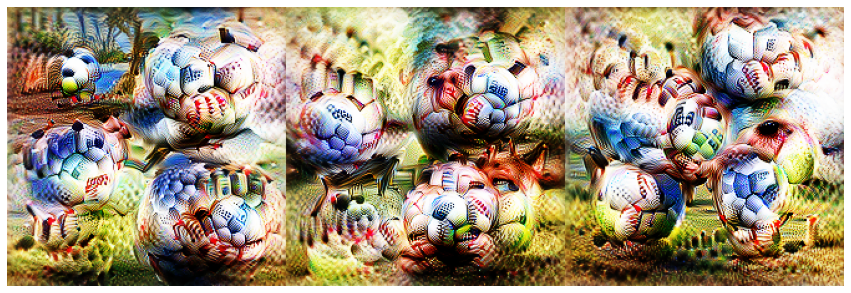

In [10]:
# Setup NaturalImage with Captum's default FFTImage
image = opt.images.NaturalImage((224, 224), parameterization=opt.images.FFTImage, batch=3).to(device)

loss_fn = opt.loss.ChannelActivation(model.mixed5a, 9)

# Use Captum's version of RandomScale
transforms = [opt.transforms.RandomScale(scale=scale_list), opt.transforms.RandomSpatialJitter(16)]

# Render the results with Captum's default learing rate
visualize(model, image, transforms, loss_fn, lr=0.025, n_iter=512)

## Lucid-like FFTImage & RandomScale

Now we can render the Lucid-like set of results for comparison using the `FFTImageLucid` and `RandomScaleLucid` classes that we defined above.

  0%|          | 0/512 [00:00<?, ? step/s]

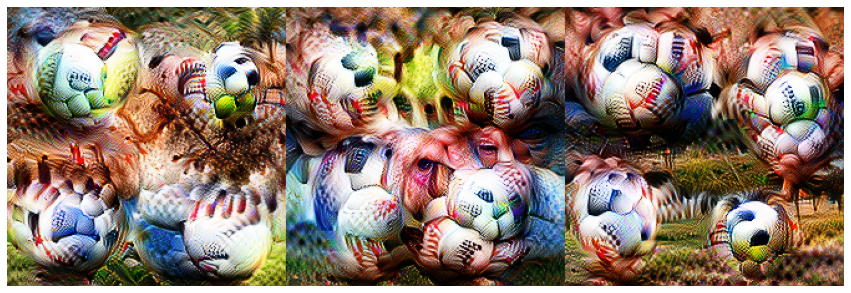

In [11]:
# Setup NaturalImage with the Lucid-like FFTImage
image = opt.images.NaturalImage((224, 224), parameterization=FFTImageLucid, batch=3).to(device)
loss_fn = opt.loss.ChannelActivation(model.mixed5a, 9)

# Use the Lucid-like version of RandomScale
transforms = [RandomScaleLucid(scale=scale_list), opt.transforms.RandomSpatialJitter(16)]

# Render the results with a more Lucid-like learning rate
visualize(model, image, transforms, loss_fn, lr=0.08, n_iter=512)

## Lucid-like FFTImage & Captum's RandomScale

To verify that the Lucid-like version of RandomScale is working like Captum's default RandomScale, we'll render a set of results using both the Lucid-like FFTImage and Captum's default RandomScale.

  0%|          | 0/512 [00:00<?, ? step/s]

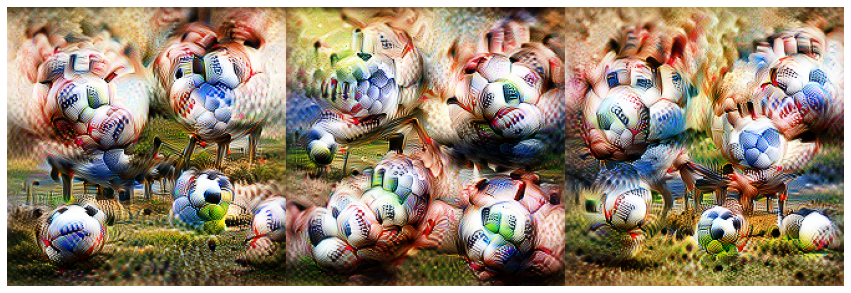

In [14]:
# Setup NaturalImage with the Lucid-like FFTImage
image = opt.images.NaturalImage((224, 224), parameterization=FFTImageLucid, batch=3).to(device)
loss_fn = opt.loss.ChannelActivation(model.mixed5a, 9)

# Use the Captum version of RandomScale
transforms = [opt.transforms.RandomScale(scale=scale_list), opt.transforms.RandomSpatialJitter(16)]

# Render the results with a more Lucid-like learning rate
visualize(model, image, transforms, loss_fn, lr=0.08, n_iter=512)

## Default Captum FFTImage & Lucid-like RandomScale

To verify that the Lucid-like version of FFTImage is working like Captum's default FFTImage, we'll render a set of results using both the Lucid-like RandomScale and Captum's default FFTImage.

  0%|          | 0/512 [00:00<?, ? step/s]

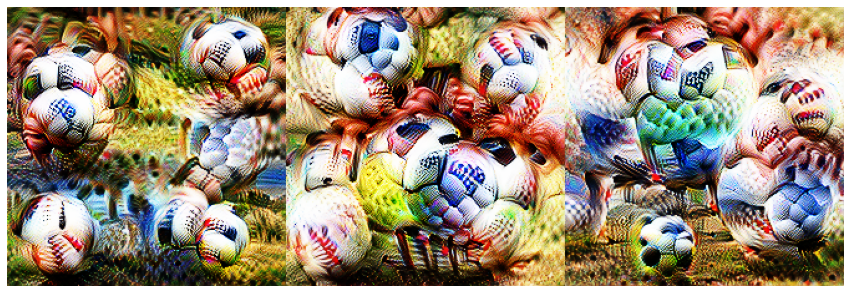

In [20]:
# Setup NaturalImage with Captum's default FFTImage
image = opt.images.NaturalImage((224, 224), parameterization=opt.images.FFTImage, batch=3).to(device)

loss_fn = opt.loss.ChannelActivation(model.mixed5a, 9)

# Use the Lucid-like version of RandomScale
transforms = [RandomScaleLucid(scale=scale_list), opt.transforms.RandomSpatialJitter(16)]

# Render the results with Captum's default learing rate
visualize(model, image, transforms, loss_fn, lr=0.025, n_iter=512)